In [11]:
from migration import security, SQL
import seaborn as sns
import matplotlib.pyplot as plt

path_security = '/home/camilo/Documentos/Globant_Challenge/sec-logs'
query1 = """
    SELECT 
    d.department AS department,
    j.jobs AS job,
    COUNT(CASE WHEN EXTRACT(QUARTER FROM he.datetime) = 1 THEN 1 END) AS Q1,
    COUNT(CASE WHEN EXTRACT(QUARTER FROM he.datetime) = 2 THEN 1 END) AS Q2,
    COUNT(CASE WHEN EXTRACT(QUARTER FROM he.datetime) = 3 THEN 1 END) AS Q3,
    COUNT(CASE WHEN EXTRACT(QUARTER FROM he.datetime) = 4 THEN 1 END) AS Q4
FROM challenge.hired_employees he
JOIN challenge.departments d ON he.department_id = d.id
JOIN challenge.jobs j ON he.job_id = j.id
WHERE EXTRACT(YEAR FROM he.datetime) = 2021
GROUP BY d.department, j.jobs
ORDER BY d.department ASC, j.jobs ASC;
"""
query2 = """
SELECT 
    d.id AS department_id,
    d.department AS department_name,
    COUNT(he.id) AS total_hired
FROM challenge.hired_employees he
JOIN challenge.departments d ON he.department_id = d.id
WHERE EXTRACT(YEAR FROM he.datetime) = 2021
GROUP BY d.id, d.department
HAVING COUNT(he.id) > (
    SELECT AVG(hired_count)
    FROM (
        SELECT COUNT(he.id) AS hired_count
        FROM challenge.hired_employees he
        WHERE EXTRACT(YEAR FROM he.datetime) = 2021
        GROUP BY he.department_id
    ) AS department_avg
)
ORDER BY total_hired DESC;

"""

In [2]:
Hermes = security(f'{path_security}/configfile.txt', f'{path_security}/logfile.log')
parameters = Hermes.config_file_read()
conector = SQL(parameters['host'],
                         parameters['DB_name'],
                         parameters['usr'],
                         parameters['psw'],
                         parameters['schema'])

In [4]:
conector.connect()
df = conector.queries(query1)
print(df)

     department                            job  q1  q2  q3  q4
0    Accounting      Account Representative IV   1   0   0   0
1    Accounting                        Actuary   0   1   0   0
2    Accounting             Analyst Programmer   0   0   1   0
3    Accounting  Budget/Accounting Analyst III   0   1   0   0
4    Accounting                Cost Accountant   0   1   0   0
..          ...                            ...  ..  ..  ..  ..
895    Training                        Teacher   0   2   0   0
896    Training               Technical Writer   0   0   1   0
897    Training          VP Product Management   1   0   0   0
898    Training             VP Quality Control   0   1   0   0
899    Training              Web Developer III   0   1   0   0

[900 rows x 6 columns]


/home/camilo/Documentos/Globant_Challenge/src/migration.py:119: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


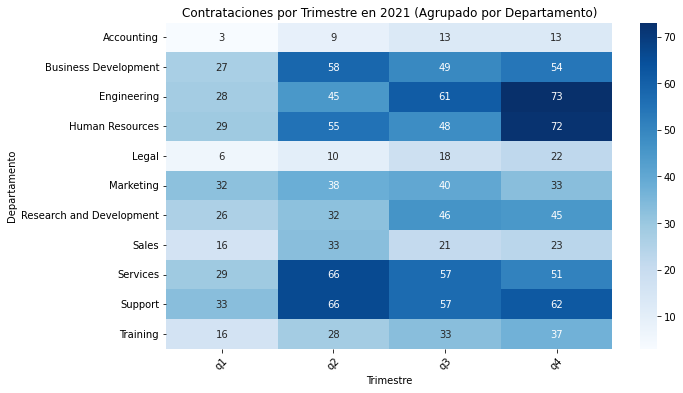

In [ ]:


df_grouped = df.groupby("department")[["q1", "q2", "q3", "q4"]].sum().reset_index()

# Reestructurar el DataFrame para el heatmap
df_melted = df_grouped.melt(id_vars=["department"], var_name="Trimestre", value_name="Contrataciones")

# Crear el heatmap
plt.figure(figsize=(10, 6))
heatmap_data = df_melted.pivot(index="department", columns="Trimestre", values="Contrataciones")

sns.heatmap(heatmap_data, cmap="Blues", annot=True, fmt="d")

plt.title("Contrataciones por Trimestre en 2021 (Agrupado por Departamento)")
plt.xlabel("Trimestre")
plt.ylabel("Departamento")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


In [13]:
conector.connect()
df = conector.queries(query2)
print(df)

   department_id           department_name  total_hired
0              8                   Support          221
1              5               Engineering          208
2              6           Human Resources          205
3              7                  Services          205
4              4      Business Development          188
5              3  Research and Development          151
6              9                 Marketing          144


/home/camilo/Documentos/Globant_Challenge/src/migration.py:119: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [17]:
mean_hired = df["total_hired"].mean()
mean_hired

188.85714285714286

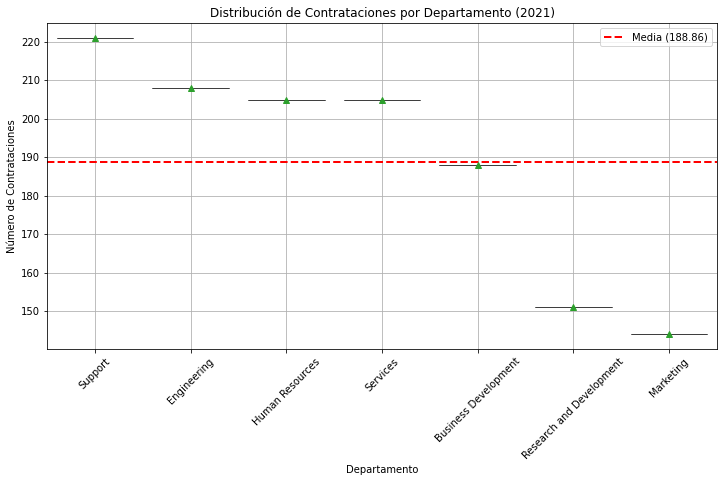

In [15]:
mean_hired = df["total_hired"].mean()

# Crear el diagrama de caja
plt.figure(figsize=(12, 6))
sns.boxplot(x="department_name", y="total_hired", data=df, showmeans=True)

# Agregar una línea horizontal en la media
plt.axhline(mean_hired, color='red', linestyle='dashed', linewidth=2, label=f"Media ({mean_hired:.2f})")

# Mejorar visualización
plt.xticks(rotation=45)
plt.title("Distribución de Contrataciones por Departamento (2021)")
plt.xlabel("Departamento")
plt.ylabel("Número de Contrataciones")
plt.legend()  # Mostrar la leyenda con la media
plt.grid(True)
plt.show()